# Introduction

The EDA aims to explore some characteristics of the dataset such as correlation between features and target and their distributions. Also to prepare the data for training the sub-models

# Import Libraries

In [1]:
# Importing libraries
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt 

In [2]:
# Importing Functions
from FunctionsEDA import CapitalizeIfNecessary , EncodeCategoricalFeature , SegmentingDatasetByCategories , PlotHistogramBox , PlotHeatmapCorrelation , PlotHistogramBox_Hue , RenameColumnLabels

# Data Cleaning [I]

The dataset was loaded and the features were classified into numerical, categorical and target type. The categorical features were encoded based on meaning of their values, in other words what represent. 

The full dataset was grouped by insufficient-normal weight, overweight and obesity because the final model will firstly estimate the probabilities of belonging to these groups and then those belonging to a certain obesity level.

In [3]:
# Loading raw dataset
ObesityDataset_Raw = pd.read_csv('ObesityDataset_Raw.csv')

In [4]:
# Getting categorical and numerical features
CategoricalFeatures = []
NumericalFeatures = []
TargetFeature = ['NObeyesdad']

for label in ObesityDataset_Raw.columns:
    if label not in TargetFeature:
        if ObesityDataset_Raw[label].dtype == 'object':
            CategoricalFeatures.append(label)
        else:
            NumericalFeatures.append(label)

In [5]:
# Capitalizing values of categorical features
ObesityDataset_Raw[CategoricalFeatures+TargetFeature] = ObesityDataset_Raw[CategoricalFeatures+TargetFeature].map(CapitalizeIfNecessary)

In [6]:
# Transforming categorical features' data type into categorical data type
ObesityDataset_Raw[CategoricalFeatures+TargetFeature] = ObesityDataset_Raw[CategoricalFeatures+TargetFeature].astype('category')

In [7]:
# Encoding categorical features into numerical features

## Feature NObeyesdad
SortedValues_NObeyesdad = ['Insufficient_Weight','Normal_Weight','Overweight_Level_I','Overweight_Level_II','Obesity_Type_I','Obesity_Type_II','Obesity_Type_III']
EncodeCategoricalFeature(ObesityDataset_Raw,'NObeyesdad',SortedValues_NObeyesdad)

## Feature Gender
Values_Gender = ['Female','Male']
EncodeCategoricalFeature(ObesityDataset_Raw,'Gender',Values_Gender)

## Feature CAEC , CALC
Values_Frequencies = ['No','Sometimes','Frequently','Always']
CategoricalFeatures_Frequencies = ['CAEC','CALC']
for feature in CategoricalFeatures_Frequencies:
    EncodeCategoricalFeature(ObesityDataset_Raw,feature,Values_Frequencies)

## Feature MTRANS
Values_MTRANS = ['Walking','Bike','Public_Transportation','Motorbike','Automobile']
EncodeCategoricalFeature(ObesityDataset_Raw,'MTRANS',Values_MTRANS)

## Other features
Values_Binary = ['No','Yes']
EncodedFeatures = set(['Gender','MTRANS']+CategoricalFeatures_Frequencies)
for feature in CategoricalFeatures:
    if feature not in EncodedFeatures:
        EncodeCategoricalFeature(ObesityDataset_Raw,feature,Values_Binary)

In [8]:
# Getting encoded categorical features
CategoricalFeatures_Encode = [feature+'_Encode' for feature in CategoricalFeatures]
TargetFeature_Encode = ['NObeyesdad_Encode']

In [9]:
# Grouping by Obesity level (NObeyesdad)
GroupObesityLevel = ObesityDataset_Raw.groupby(by=TargetFeature,observed=True)

# Segmenting Dataset by Obesity levels
ObesityLevels = dict()
for obesity_level in ObesityDataset_Raw['NObeyesdad'].unique():
    ObesityLevels[obesity_level] = GroupObesityLevel.get_group((obesity_level,))

## Insufficient and Normal Weight
ObesityLevels_Group1 = ['Insufficient_Weight','Normal_Weight']
ObesityDataset_Group1 = SegmentingDatasetByCategories(ObesityLevels,'NObeyesdad',ObesityLevels_Group1)

## Overweight 
ObesityLevels_Group2 = ['Overweight_Level_I','Overweight_Level_II']
ObesityDataset_Group2 = SegmentingDatasetByCategories(ObesityLevels,'NObeyesdad',ObesityLevels_Group2)

## Obesity
ObesityLevels_Group3 = ['Obesity_Type_I','Obesity_Type_II','Obesity_Type_III']
ObesityDataset_Group3 = SegmentingDatasetByCategories(ObesityLevels,'NObeyesdad',ObesityLevels_Group3)

In [10]:
# Re-encoding Obesity Level based on groups
ObesityDataset_Groups = ObesityDataset_Raw.copy(deep=True)
Encoder_ObesityLevelGroups = {obesity_level:group_num for group_num , group_ObesityLevel in enumerate([ObesityLevels_Group1,ObesityLevels_Group2,ObesityLevels_Group3]) for obesity_level in group_ObesityLevel}
ObesityDataset_Groups['NObeyesdad_Encode'] = ObesityDataset_Groups['NObeyesdad'].map(Encoder_ObesityLevelGroups).astype(int)

# Grouping obesity levels
ObesityLevelGroups = ['Insufficient-Normal Weight','Overweight', 'Obesity']
Decoder_ObesityLevelGroups = {group_num:group_ObesityLevel for group_num , group_ObesityLevel in enumerate(ObesityLevelGroups)}
ObesityDataset_Groups['NObeyesdad'] = ObesityDataset_Groups['NObeyesdad_Encode'].map(Decoder_ObesityLevelGroups).astype('category')

# Data Analysis

In the full dataset, the amount of records with the different combinations of Obesity Level and Gender were counted and the features' distribution were plotted to show their possible distributions. 

It was plotted the correlation matrix in each sub dataset [by Groups, Group 1, Group 2 and Group 3] to show lineal relation between features and the target and some observations were made about the interaction between features and mainly with the target.

## Full Dataset

Wether the records in the dataset are counted by obesity level and gender, can be seen that the number of records in some pair of values is almost nil compared to others. For example, in obesity type II and obesity type III is observed this situation.

Therefore obesity type II, female and obesity type III, male are clases with low representation, so (preliminarily) the final model will not be able to learn enough to estimate probabilities in samples with this features and categories. But in the others will not apparently show this type of difficult.

In [11]:
# Counting records by Obesity Level and Gender
ObesityDataset_Raw[['NObeyesdad','Gender']].value_counts()

NObeyesdad           Gender
Obesity_Type_III     Female    323
Obesity_Type_II      Male      295
Obesity_Type_I       Male      195
Overweight_Level_II  Male      187
Insufficient_Weight  Female    173
Obesity_Type_I       Female    156
Normal_Weight        Male      146
Overweight_Level_I   Female    145
                     Male      145
Normal_Weight        Female    141
Overweight_Level_II  Female    103
Insufficient_Weight  Male       99
Obesity_Type_II      Female      2
Obesity_Type_III     Male        1
Name: count, dtype: int64

Some of the features do not have a clear distribution except age, height and weight. The former is like a $\chi^2$ distribution and the last are like normal distribution. And the target feature seems like a normal distribution which tend to be uniform.

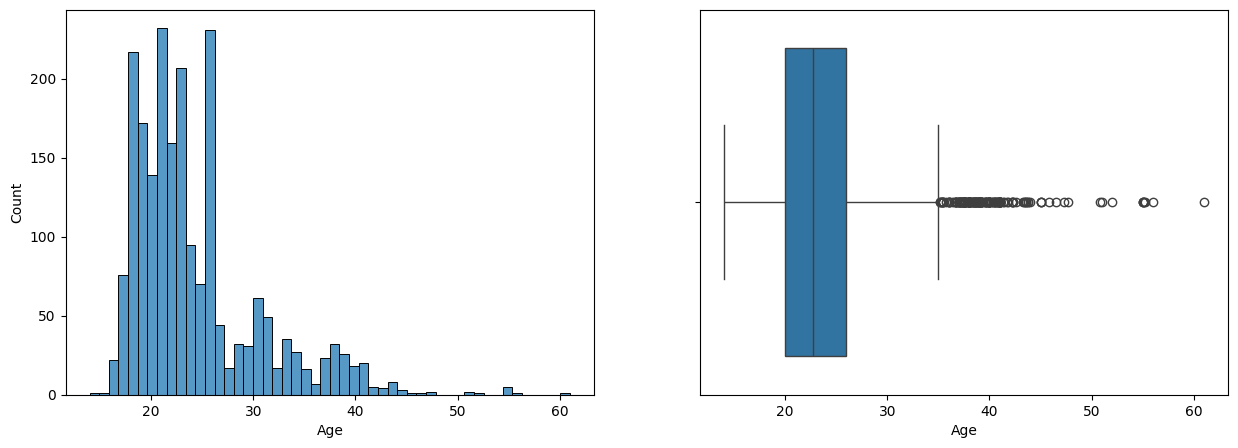

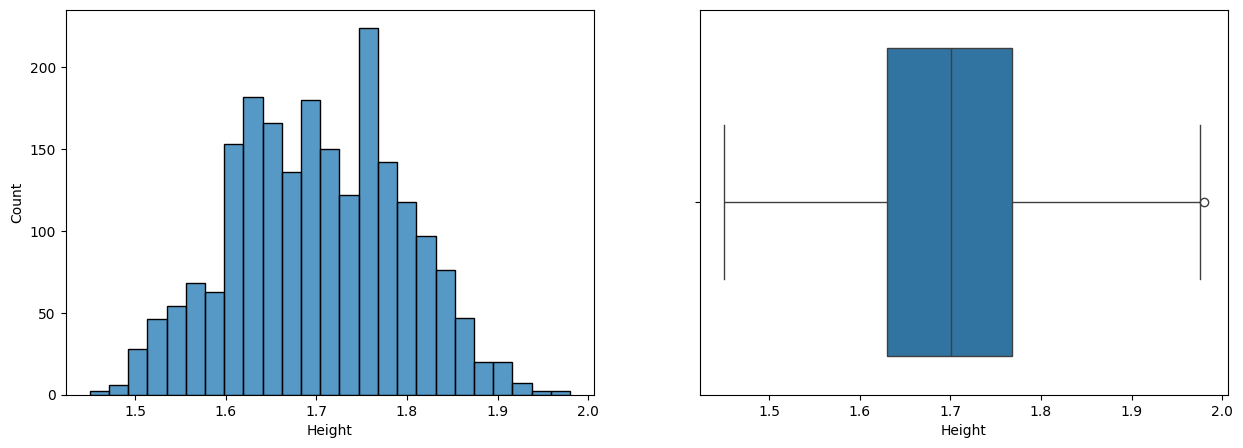

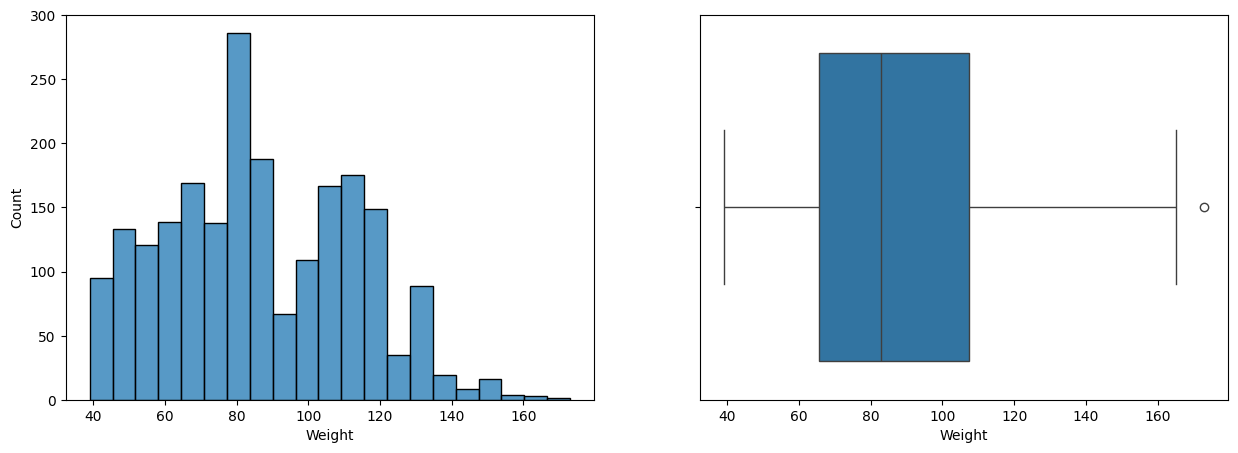

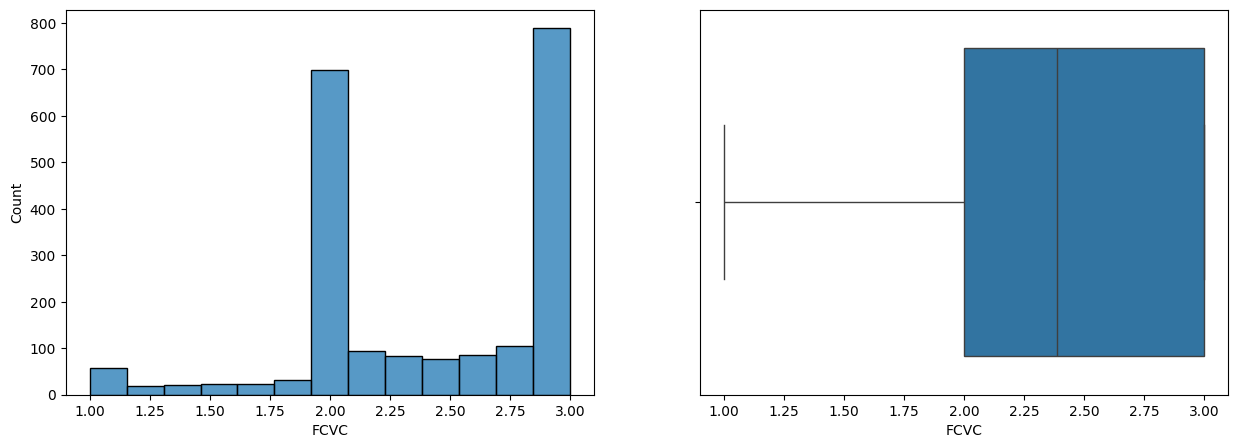

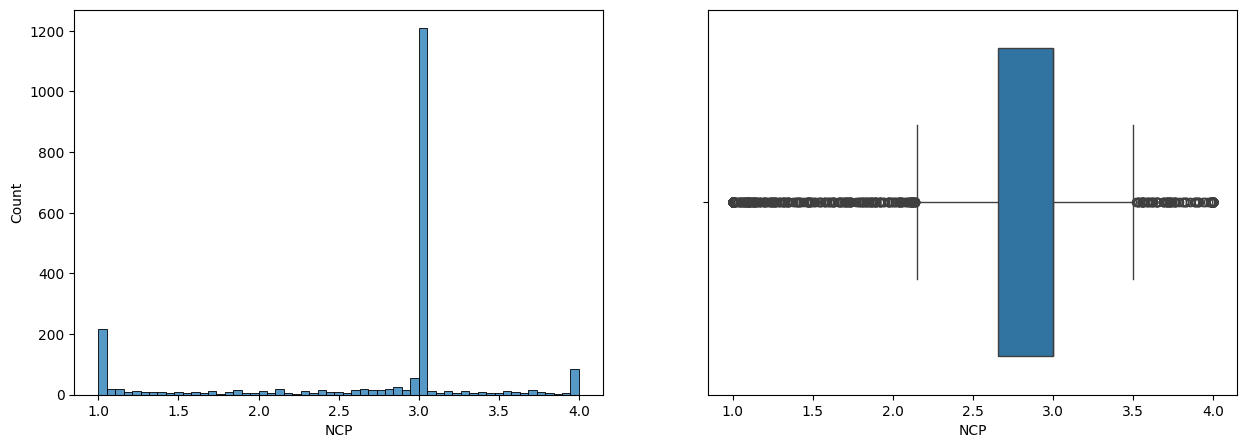

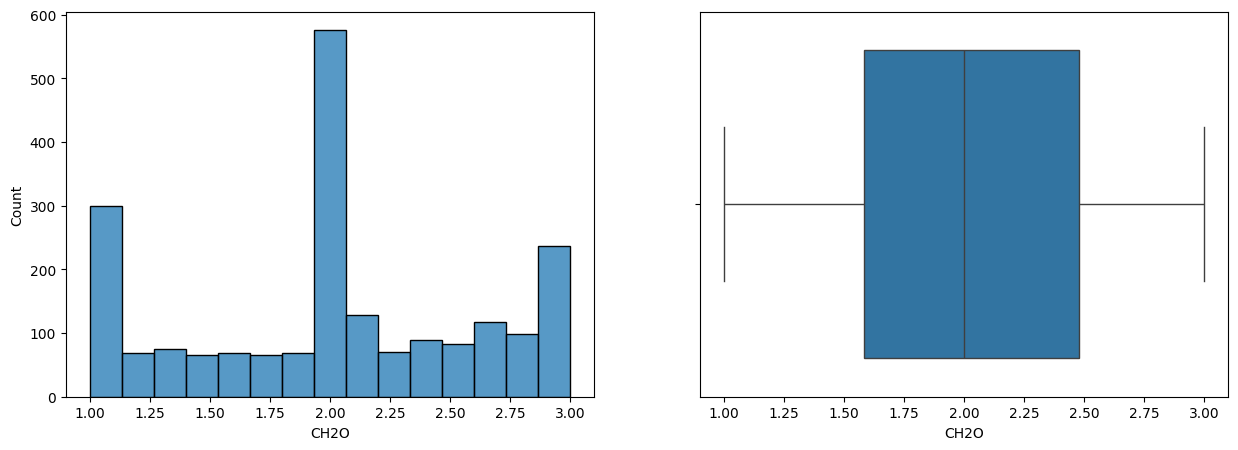

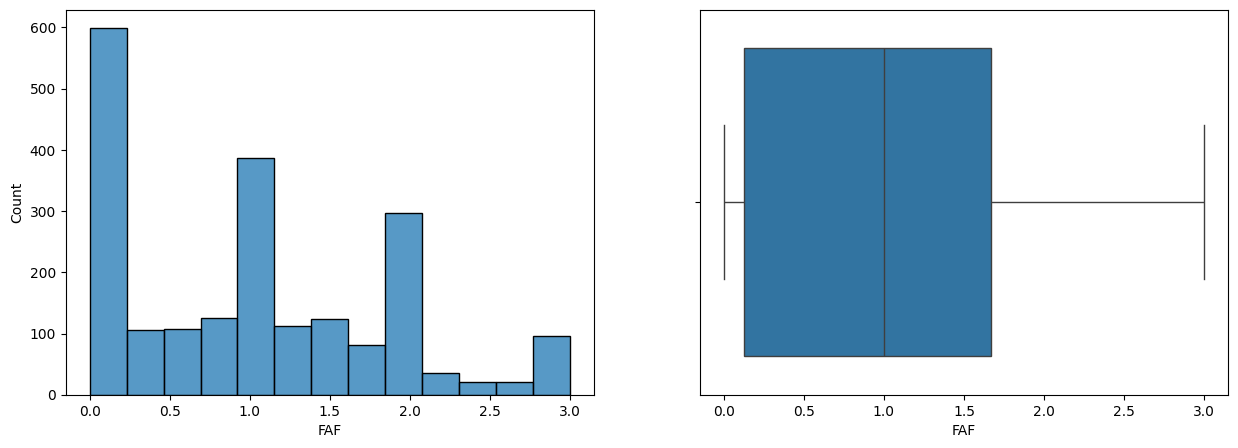

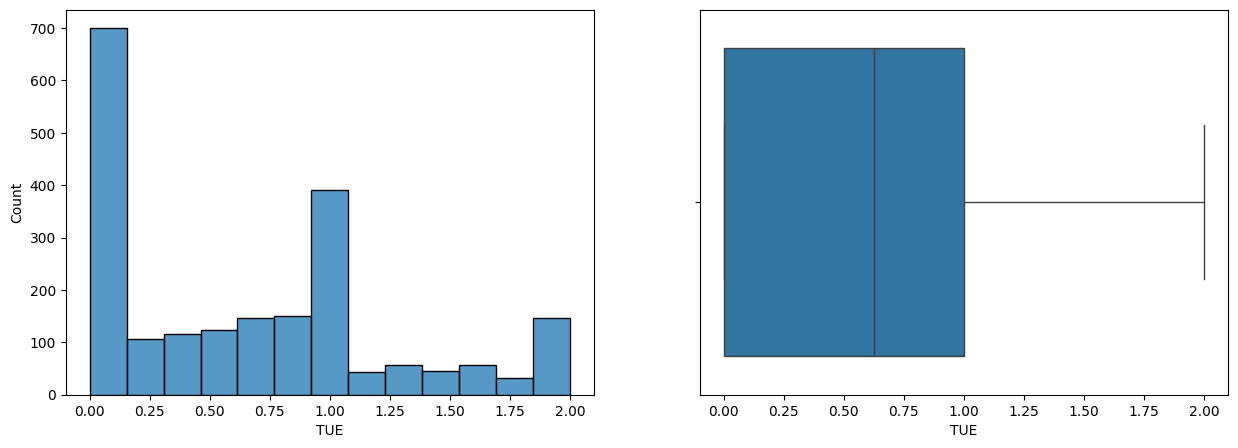

In [12]:
for feature in NumericalFeatures:
    PlotHistogramBox(ObesityDataset_Raw,feature,'Numerical')

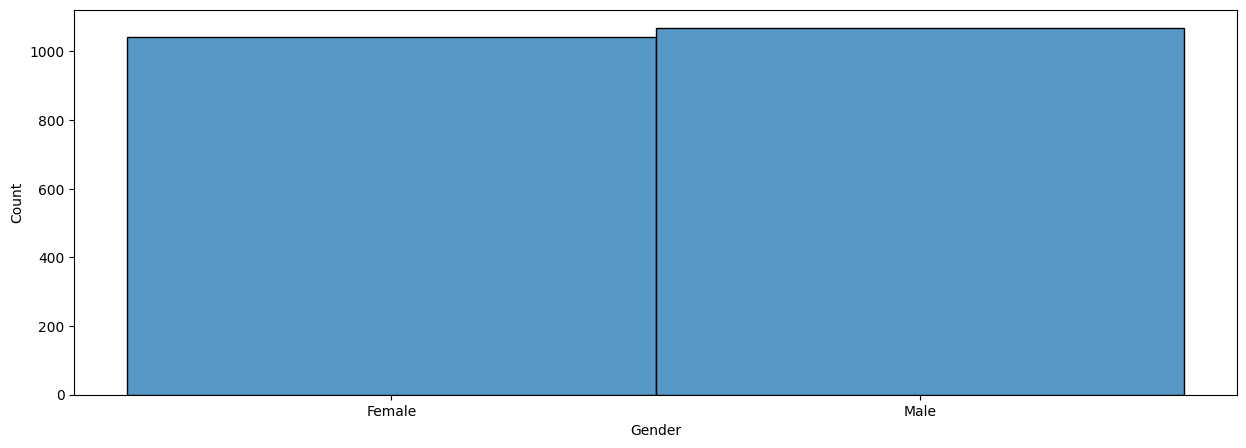

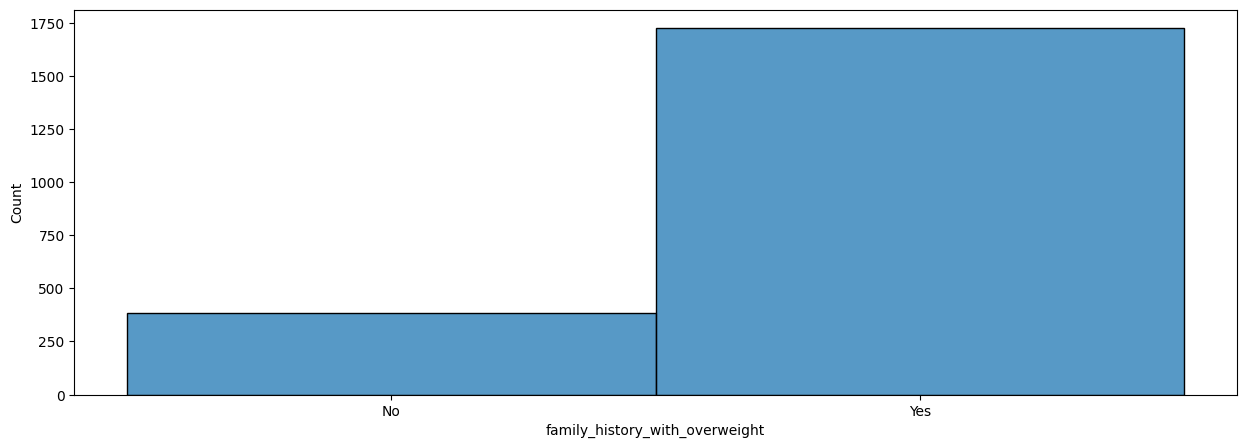

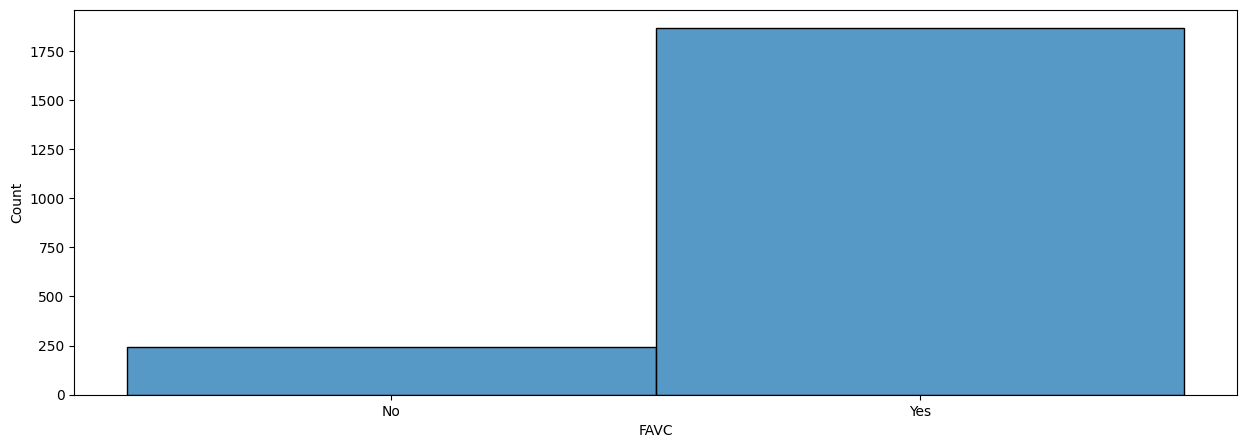

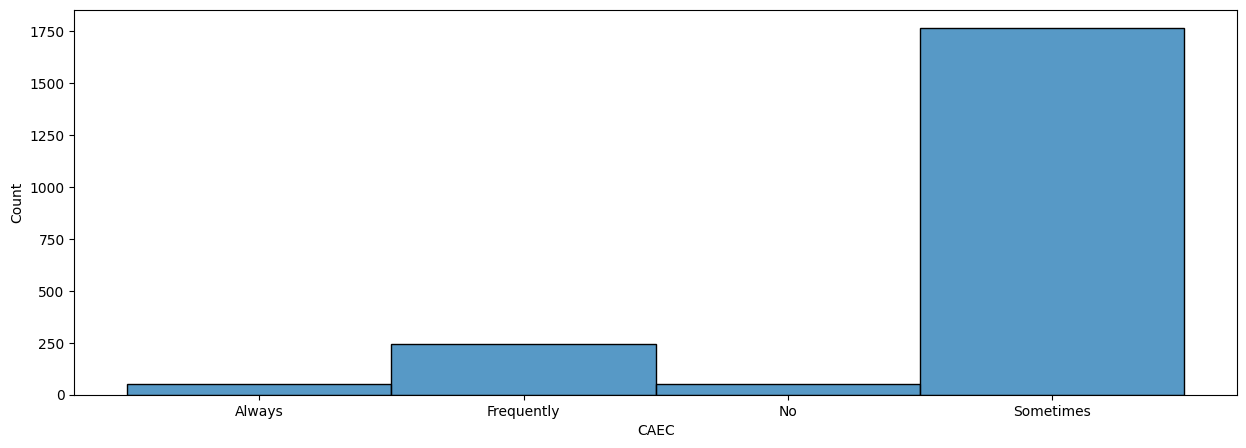

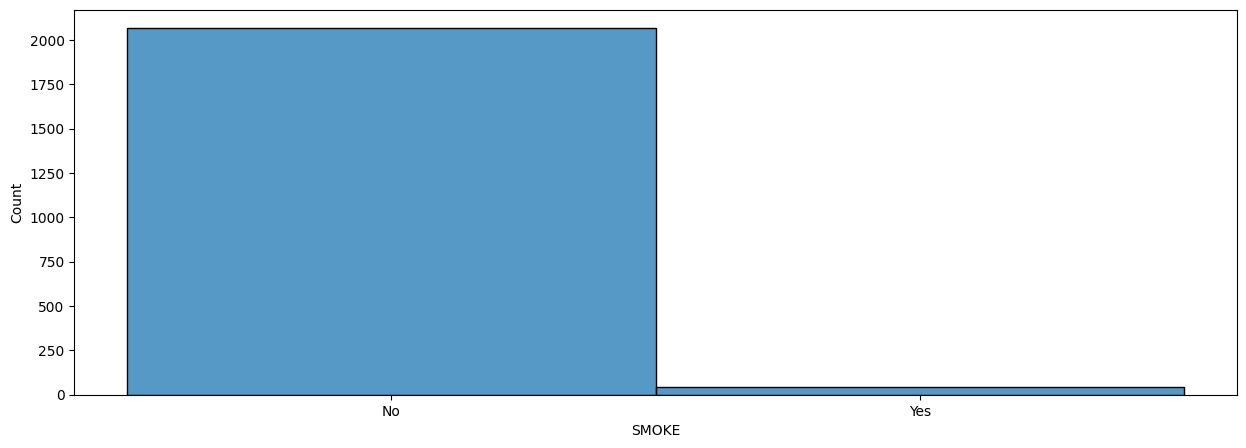

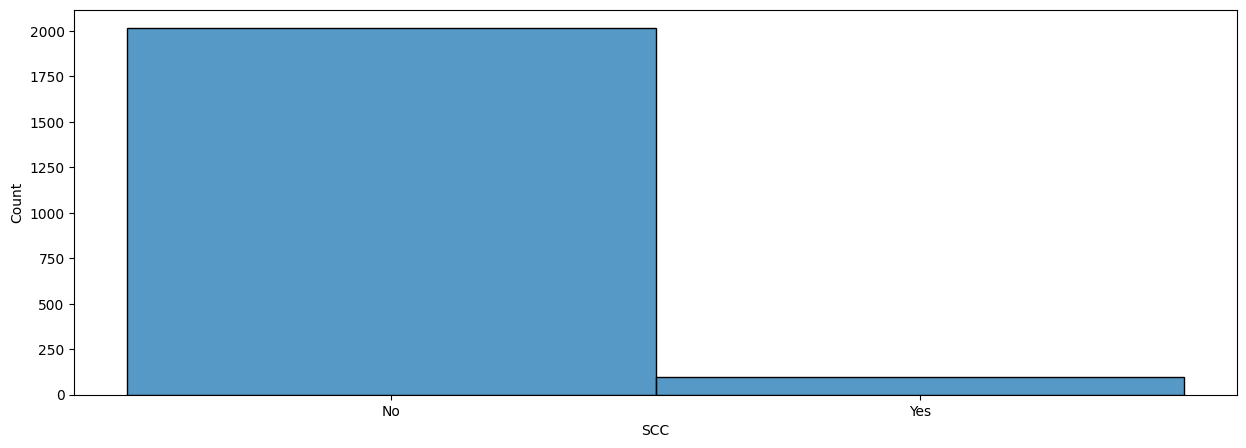

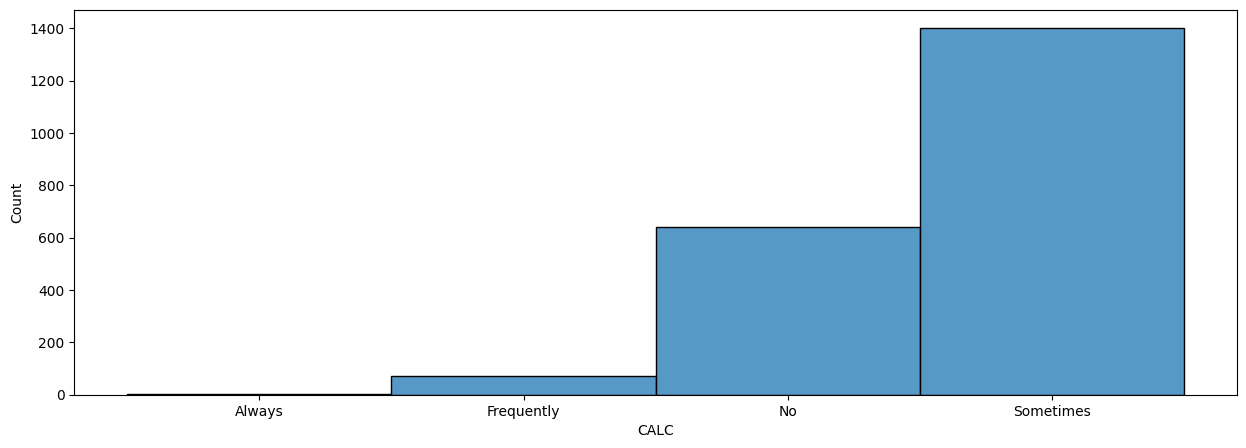

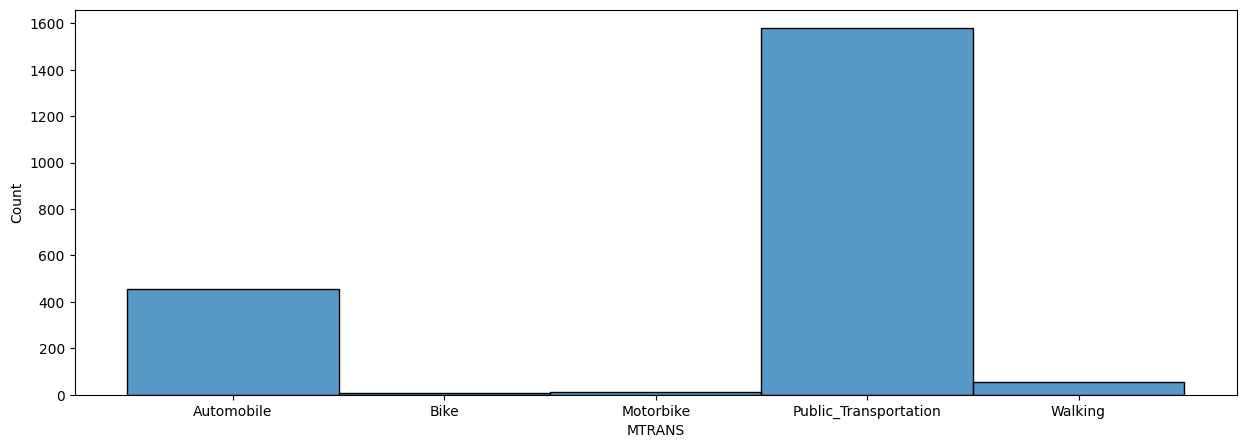

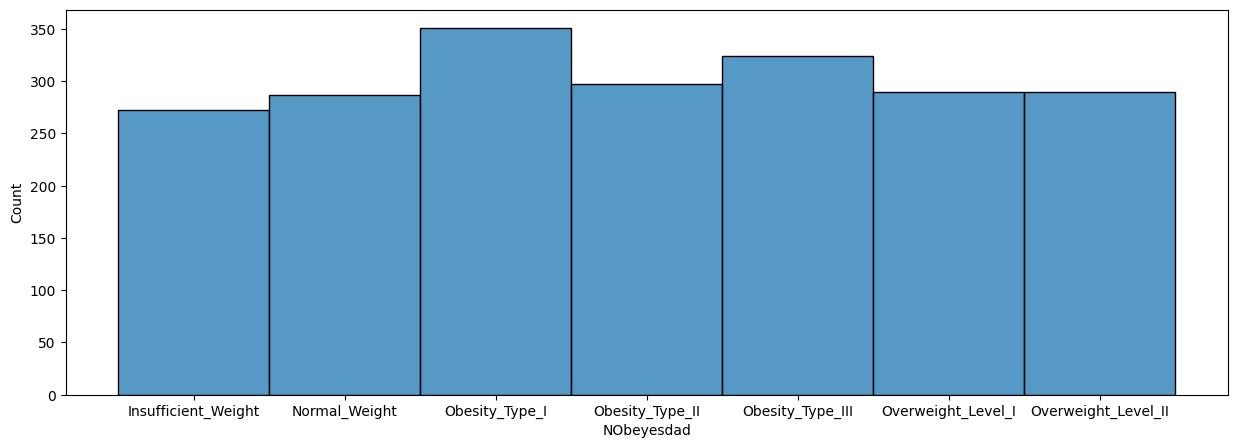

In [13]:
for feature in CategoricalFeatures+TargetFeature:
    PlotHistogramBox(ObesityDataset_Raw,feature,'Categorical')

## Dataset by Groups

In the dataset by groups, age, weight, family history with overweight, FAVC (eat high caloric food frequently) and CAEC (eat any food between meals) are feature that are more correlated with the target feature. The weight having the greatest impact on predicting the target's value.

Other features do not show a hight correlation value with the target features, implies that either are independent variables or their interaction is no lineal. 

Another observation to be made is that the another features related to habits may not be relevant to classify a data point into Insufficient-Normal Weight, Overweight or Obesity [class for the first sub-model] but be to distinguish between obesity levels. 

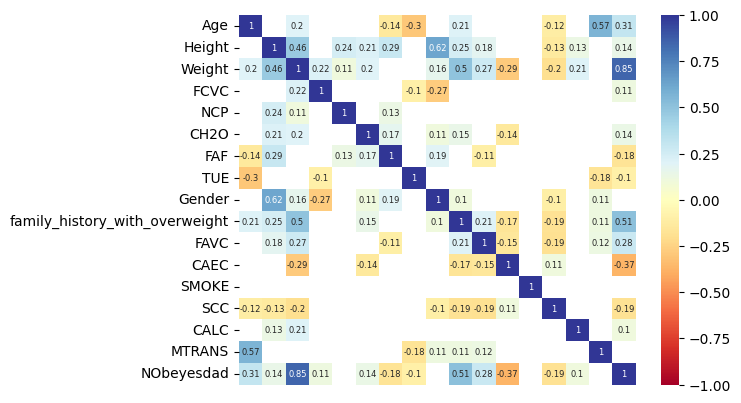

In [14]:
# Plotting correlation between features in grouped dataset
Features_Encode = NumericalFeatures+CategoricalFeatures_Encode+TargetFeature_Encode
TickLabels_Y = NumericalFeatures+CategoricalFeatures+TargetFeature
PlotHeatmapCorrelation(ObesityDataset_Groups,Features_Encode,TickLabels_Y)

The distribution of some features with a high correlation with the target, show that certain values in these features allow distinguish between groups. Therefor certain values will determine to which group belongs.

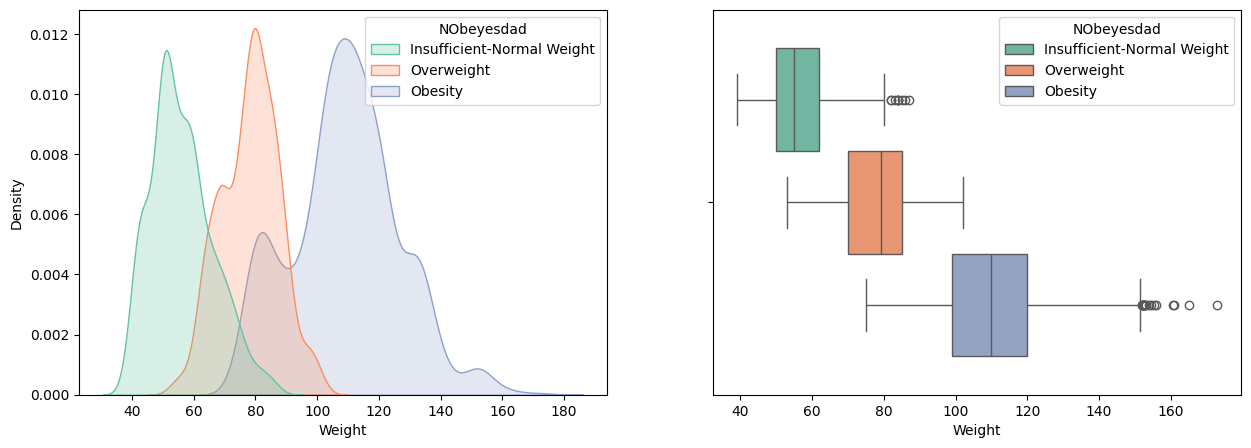

In [15]:
PlotHistogramBox_Hue(ObesityDataset_Groups,'Weight','NObeyesdad',ObesityLevelGroups)

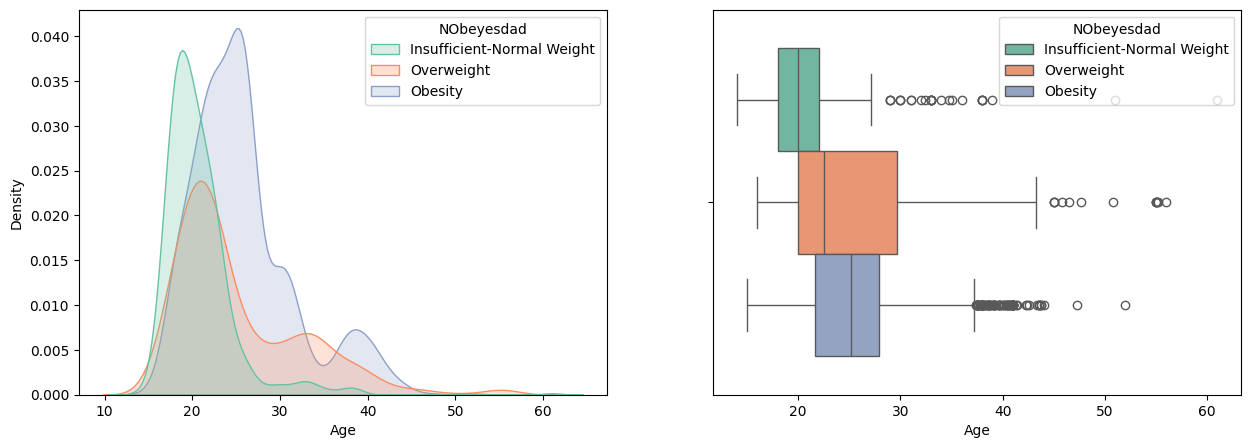

In [16]:
PlotHistogramBox_Hue(ObesityDataset_Groups,'Age','NObeyesdad',ObesityLevelGroups)

<Axes: xlabel='family_history_with_overweight', ylabel='Count'>

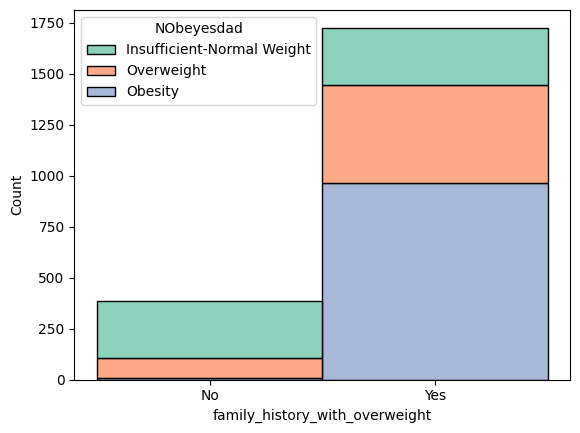

In [17]:
sns.histplot(ObesityDataset_Groups,x='family_history_with_overweight',hue='NObeyesdad',hue_order=ObesityLevelGroups,multiple='stack',palette='Set2')

<Axes: xlabel='FAVC', ylabel='Count'>

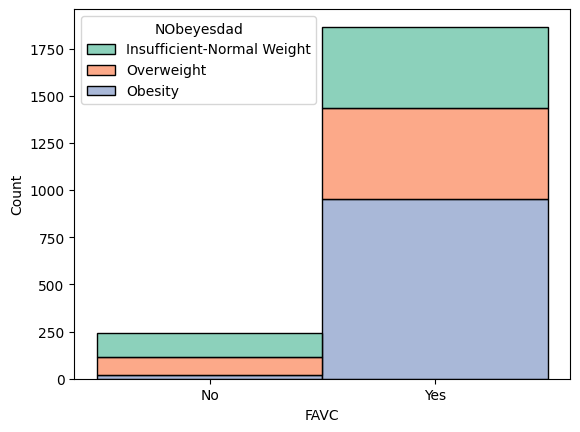

In [18]:
sns.histplot(ObesityDataset_Groups,x='FAVC',hue='NObeyesdad',hue_order=ObesityLevelGroups,multiple='stack',palette='Set2')

<Axes: xlabel='CAEC', ylabel='Count'>

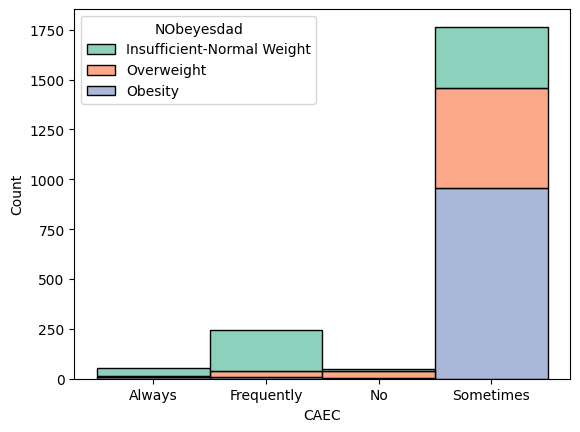

In [19]:
sns.histplot(ObesityDataset_Groups,x='CAEC',hue='NObeyesdad',hue_order=ObesityLevelGroups,multiple='stack',palette='Set2')

<Axes: xlabel='NObeyesdad', ylabel='Count'>

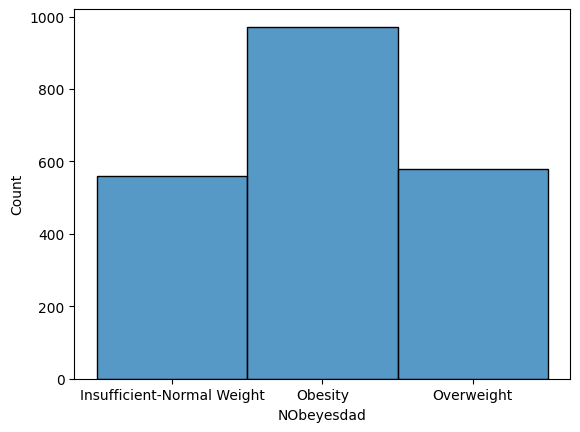

In [20]:
sns.histplot(ObesityDataset_Groups,x='NObeyesdad')

## Dataset Group 1 :: Insufficient - Normal Weight

In the datasets group 1, the features related to habits do not have a high correlation with the target, but with others features. This mean that these features have a no lineal relation with the target. 

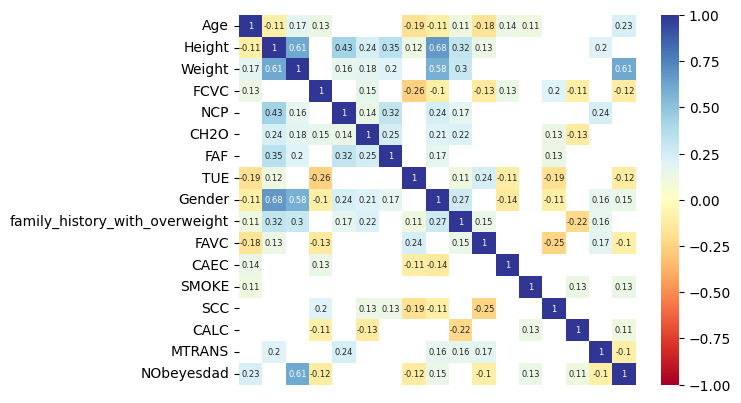

In [21]:
# Plotting correlation between features in group 1 :: Insufficient and Normal weight
PlotHeatmapCorrelation(ObesityDataset_Group1,Features_Encode,TickLabels_Y)

The plots of weight versus some features with low correlation with the target show how certain combinations of values allow distinguish between Insufficient and Normal.

<Axes: xlabel='Weight', ylabel='NCP'>

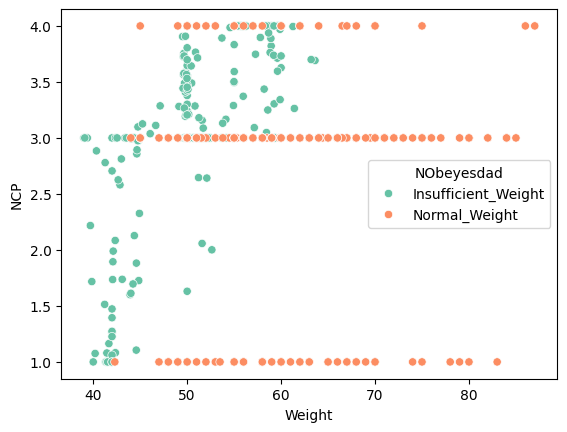

In [22]:
sns.scatterplot(ObesityDataset_Group1,x='Weight',y='NCP',hue='NObeyesdad',palette='Set2')

<Axes: xlabel='Weight', ylabel='CH2O'>

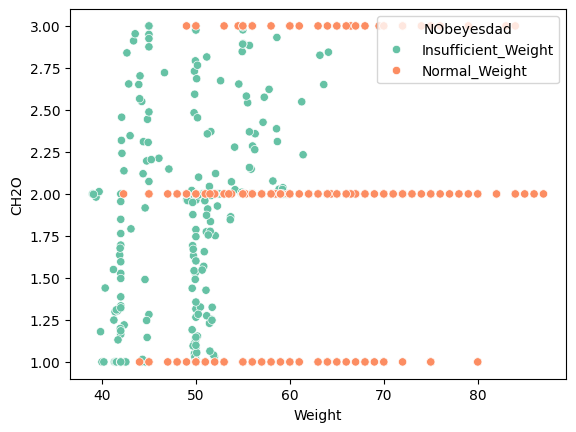

In [23]:
sns.scatterplot(ObesityDataset_Group1,x='Weight',y='CH2O',hue='NObeyesdad',palette='Set2')

<Axes: xlabel='Weight', ylabel='family_history_with_overweight'>

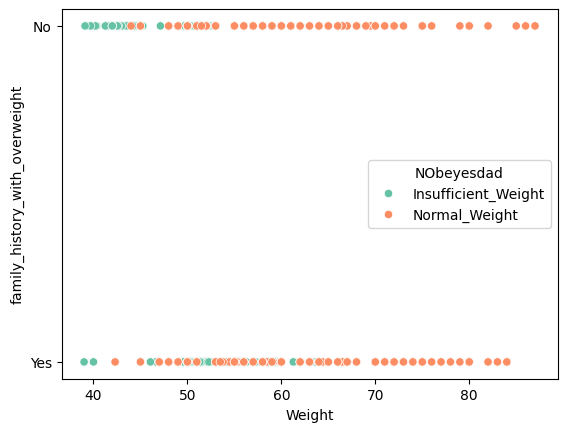

In [24]:
sns.scatterplot(ObesityDataset_Group1,x='Weight',y='family_history_with_overweight',hue='NObeyesdad',palette='Set2')

<Axes: xlabel='Weight', ylabel='SCC'>

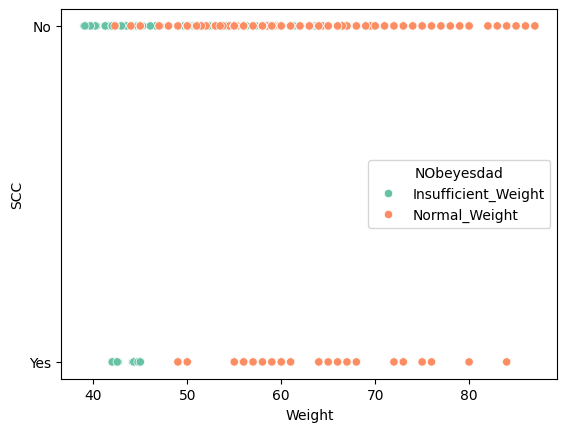

In [25]:
sns.scatterplot(ObesityDataset_Group1,x='Weight',y='SCC',hue='NObeyesdad',palette='Set2')

## Dataset Group 2 :: Overweight

In the datasets group 2, the features related to habits have a bit higher correlation with the target, and also with others features. This mean that these features tend to have a lineal relation with the target. 

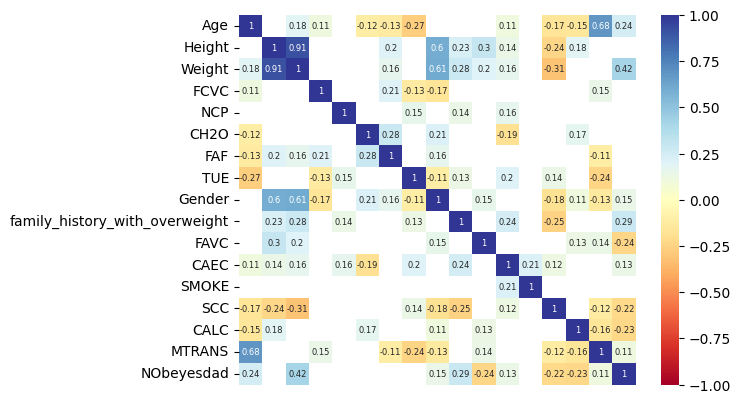

In [26]:
# Plotting correlation between features in group 2 :: Overweight
PlotHeatmapCorrelation(ObesityDataset_Group2,Features_Encode,TickLabels_Y)

The plots of weight and age versus some features with high correlation with the target show how certain combinations of values allow distinguish between Overweight Level I and II. Also show a preference, by way of distribution, how this happens.

<Axes: xlabel='Weight', ylabel='SCC'>

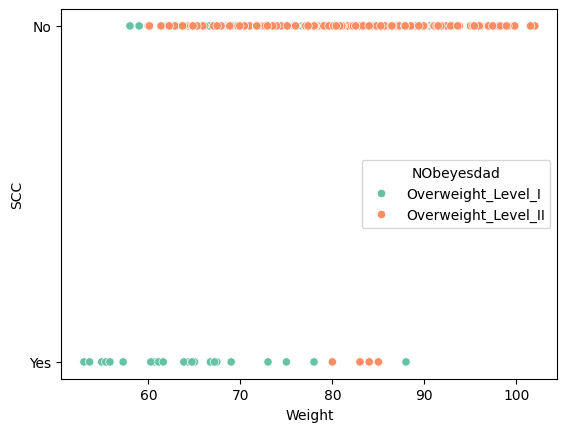

In [27]:
sns.scatterplot(ObesityDataset_Group2,x='Weight',y='SCC',hue='NObeyesdad',palette='Set2')

<Axes: xlabel='Weight', ylabel='CALC'>

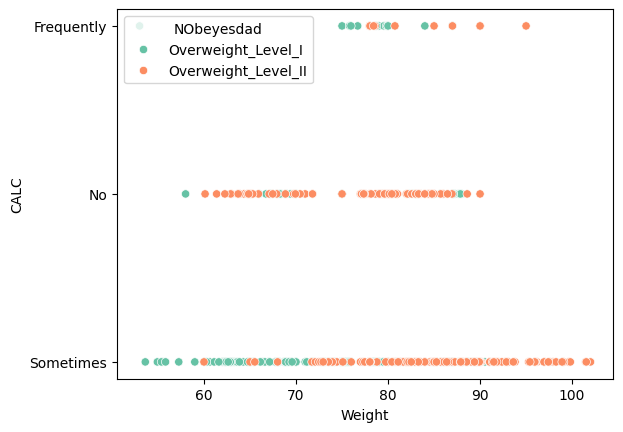

In [28]:
sns.scatterplot(ObesityDataset_Group2,x='Weight',y='CALC',hue='NObeyesdad',palette='Set2')

<Axes: xlabel='Weight', ylabel='family_history_with_overweight'>

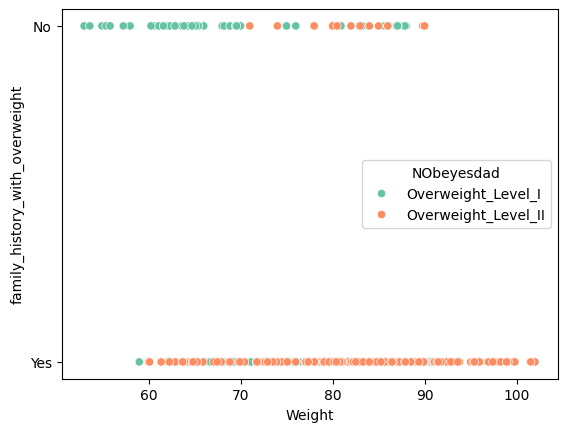

In [29]:
sns.scatterplot(ObesityDataset_Group2,x='Weight',y='family_history_with_overweight',hue='NObeyesdad',palette='Set2')

<Axes: xlabel='Age', ylabel='CAEC'>

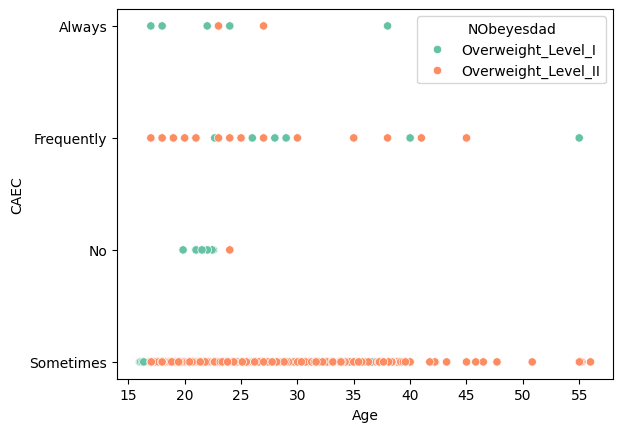

In [30]:
sns.scatterplot(ObesityDataset_Group2,x='Age',y='CAEC',hue='NObeyesdad',palette='Set2')

## Dataset Group 3 :: Obesity

In the datasets group 3, the features related to habits have a higher correlation with the others features (including the target). This mean that the features are more sensitive for predicting the target.

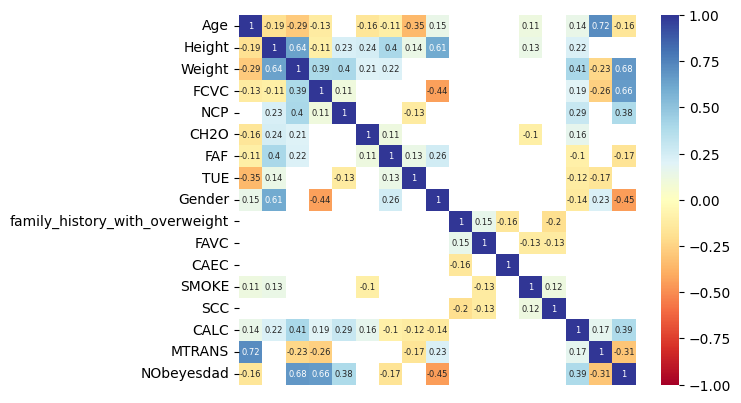

In [31]:
# Plotting correlation between features in group 3 :: Obesity
PlotHeatmapCorrelation(ObesityDataset_Group3,Features_Encode,TickLabels_Y)

The plots of weight versus some features with high correlation with the target show patterns between the target and certain combinations of values. Therefore, these values allow distinguish between Obesity Type I, II and III.

<Axes: xlabel='Weight', ylabel='FCVC'>

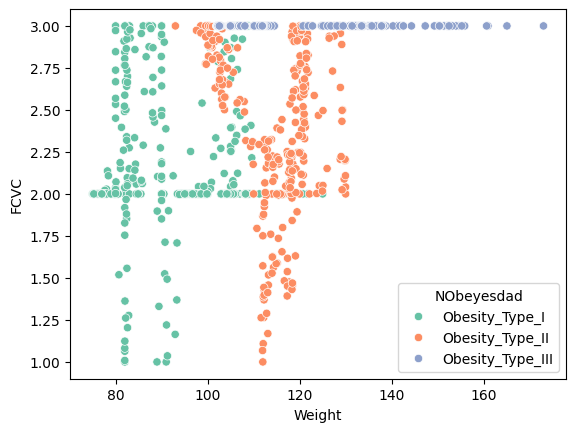

In [32]:
sns.scatterplot(ObesityDataset_Group3,x='Weight',y='FCVC',hue='NObeyesdad',palette='Set2')

<Axes: xlabel='Weight', ylabel='NCP'>

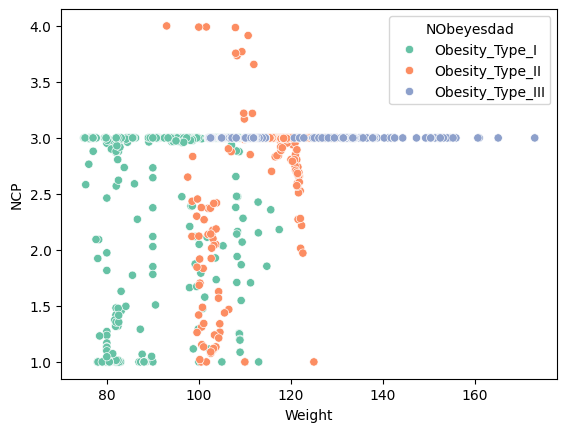

In [33]:
sns.scatterplot(ObesityDataset_Group3,x='Weight',y='NCP',hue='NObeyesdad',palette='Set2')

<Axes: xlabel='Weight', ylabel='Gender'>

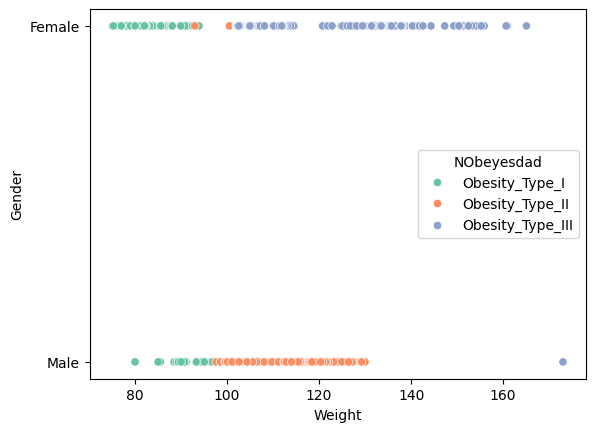

In [34]:
sns.scatterplot(ObesityDataset_Group3,x='Weight',y='Gender',hue='NObeyesdad',palette='Set2')

# Data Cleaning [II]

The full and sub datasets with the encoded and numerical features were saved as CSV file. It was not necessary to eliminate the outliers because they contain useful information for a proper classification and estimation.

In [35]:
# Save Full and Sub Datasets as CSV files
FeaturesSubset = NumericalFeatures + CategoricalFeatures_Encode + TargetFeature_Encode

ApplyRenameLabels = RenameColumnLabels(FeaturesSubset,NumericalFeatures+CategoricalFeatures+TargetFeature)

ApplyRenameLabels(ObesityDataset_Raw).to_csv('./ObesityDataset_Clean.csv')
ApplyRenameLabels(ObesityDataset_Groups).to_csv('./ObesityLevel_Groups.csv')
ApplyRenameLabels(ObesityDataset_Group1).to_csv('./ObesityLevel_Group1.csv')
ApplyRenameLabels(ObesityDataset_Group2).to_csv('./ObesityLevel_Group2.csv')
ApplyRenameLabels(ObesityDataset_Group3).to_csv('./ObesityLevel_Group3.csv')